In [39]:
 # TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.2.0


## Import fashion MNIST dataset

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
np.random.seed(1402)
tf.random.set_seed(1981)

x_train, y_train, x_valid, y_valid, x_test ,y_test = [], [], [], [], [], []
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(60000,28,28)
x_test = x_test.reshape(10000,28,28)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

x_train = x_train.reshape(len(x_train),28,28)
x_test = x_test.reshape(10000,28,28)
x_valid = x_valid.reshape(len(x_valid),28,28)

y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
y_test = keras.utils.to_categorical(y_test, 10)


In [0]:
# available labels for classification problem
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

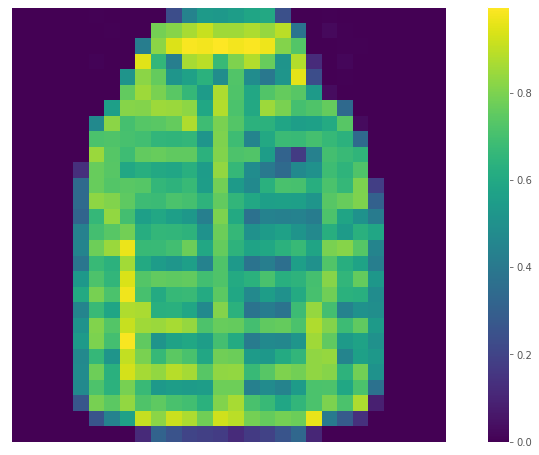

Item of type : Coat


In [42]:
# example image from the dataset
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()
print('Item of type :',class_names[np.argmax(y_train[0])])

# Helper Functions

In [0]:
# summarize history for accuracy in a plot
def plotAccuracy(someHistory):
  plt.style.use('dark_background')
  plt.rcParams['figure.figsize'] = [15, 8]
  plt.rcParams['font.size'] = 16
  plt.plot(someHistory.history['accuracy'])
  plt.plot(someHistory.history['val_accuracy'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [0]:
# summarize history for loss in a plot
def plotLoss(someHistory):
  plt.style.use('dark_background')
  plt.rcParams['figure.figsize'] = [15, 8]
  plt.rcParams['font.size'] = 16
  plt.plot(someHistory.history['loss'])
  plt.plot(someHistory.history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [0]:
# summarize history for loss and accuracy metrics in all 3 datasets (train,validation,loss)
def evaluateModel(someModel,someHistory):
  evaluationResult = someModel.evaluate(x_test, y_test, verbose=2)
  print("Train Loss     : {0:.5f}".format(someHistory.history['loss'][-1]))
  print("Validation Loss: {0:.5f}".format(someHistory.history['val_loss'][-1]))
  print("Test Loss      : {0:.5f}".format(evaluationResult[0]))
  print("---")
  print("Train Accuracy     : {0:.5f}".format(someHistory.history['accuracy'][-1]))
  print("Validation Accuracy: {0:.5f}".format(someHistory.history['val_accuracy'][-1]))
  print("Test Accuracy      : {0:.5f}".format(evaluationResult[1]))

In [0]:
# helper function to plot correctly vs misclassified images
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  true_labelInd = np.argmax(predictions_array)

  if predicted_label == true_labelInd:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_labelInd]),
                                color=color)

In [0]:
# helper function to create a barplot of predicted propabilities per label class
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color='grey')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  true_labelInd = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_labelInd].set_color('blue')

In [0]:
# creates a generic classification report showing: 
# -- correct predicted vs incorrect predicted classes
# -- sklearn classification_report() to show accuracy, precision and f1-score
# -- the output of plot_image & plot_value_array
def clasfication_report(aModel):
  num_rows = 10
  num_cols = 3
  num_images = num_rows*num_cols
  plt.style.use('ggplot')
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  predictions = aModel.predict(x_test)

  y_test_lbl = np.where(y_test==1)[1]
  y_pred_lbl = np.argmax(predictions, axis=1)

  correct = sum(y_test_lbl==y_pred_lbl)
  incorrect = sum(y_test_lbl!=y_pred_lbl)
  print("Correctly predicted classes:",correct)
  print("Incorrectly predicted classes:",incorrect)
  print()
  print(classification_report(y_test_lbl, y_pred_lbl, target_names=class_names))
  print()
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
  plt.tight_layout()
  plt.show()

In [0]:
# creates an early stoping callback monitoring val_accuracy to be used when fitting the model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Simple MLP 

In [0]:
modelMLP = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(64, kernel_initializer='normal', activation='tanh'),
    keras.layers.Dense(10, kernel_initializer='normal', activation='softmax')
])

In [51]:
modelMLP.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [0]:
modelMLP.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [53]:
historyMLP = modelMLP.fit(x_train, y_train,
					epochs=100,
					verbose=2,
          callbacks=[early_stopping_cb],
					validation_data=(x_valid, y_valid))

Epoch 1/100
1500/1500 - 5s - loss: 0.5478 - accuracy: 0.8092 - val_loss: 0.4284 - val_accuracy: 0.8456
Epoch 2/100
1500/1500 - 5s - loss: 0.3871 - accuracy: 0.8591 - val_loss: 0.3747 - val_accuracy: 0.8674
Epoch 3/100
1500/1500 - 5s - loss: 0.3523 - accuracy: 0.8715 - val_loss: 0.3615 - val_accuracy: 0.8726
Epoch 4/100
1500/1500 - 5s - loss: 0.3290 - accuracy: 0.8802 - val_loss: 0.3646 - val_accuracy: 0.8717
Epoch 5/100
1500/1500 - 5s - loss: 0.3120 - accuracy: 0.8863 - val_loss: 0.3473 - val_accuracy: 0.8766
Epoch 6/100
1500/1500 - 5s - loss: 0.2989 - accuracy: 0.8903 - val_loss: 0.3463 - val_accuracy: 0.8790
Epoch 7/100
1500/1500 - 5s - loss: 0.2871 - accuracy: 0.8945 - val_loss: 0.3491 - val_accuracy: 0.8784
Epoch 8/100
1500/1500 - 5s - loss: 0.2778 - accuracy: 0.8983 - val_loss: 0.3334 - val_accuracy: 0.8820
Epoch 9/100
1500/1500 - 5s - loss: 0.2686 - accuracy: 0.9014 - val_loss: 0.3318 - val_accuracy: 0.8825
Epoch 10/100
1500/1500 - 5s - loss: 0.2615 - accuracy: 0.9029 - val_loss:

313/313 - 1s - loss: 0.3439 - accuracy: 0.8819
Train Loss     : 0.19525
Validation Loss: 0.34238
Test Loss      : 0.34395
---
Train Accuracy     : 0.92829
Validation Accuracy: 0.88533
Test Accuracy      : 0.88190



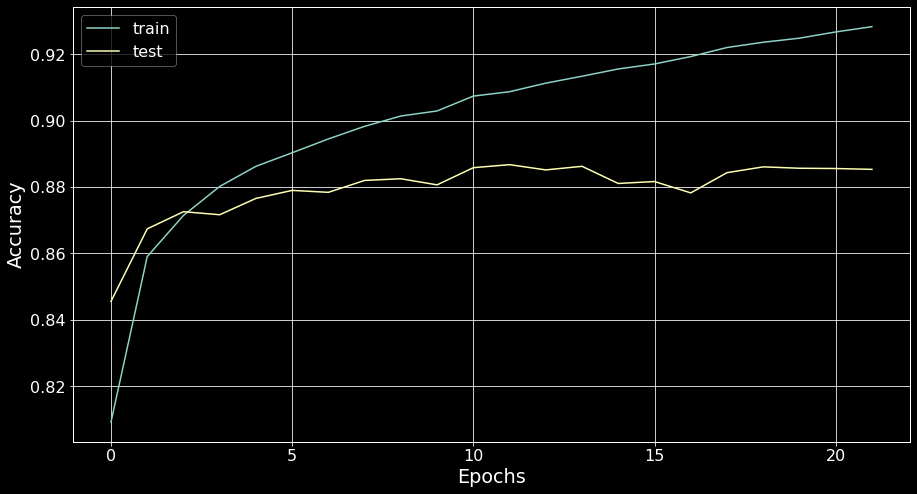

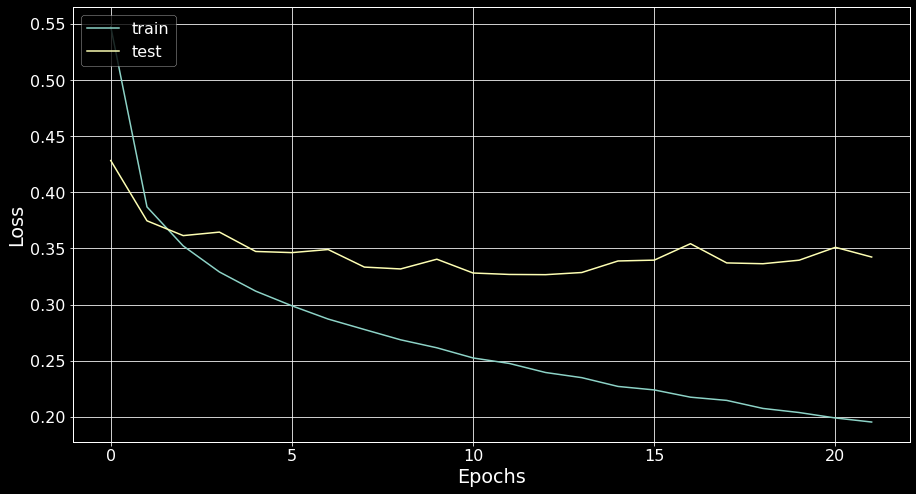

In [54]:
evaluateModel(modelMLP,historyMLP)
print()
plotAccuracy(historyMLP)
print()
plotLoss(historyMLP)

Correctly predicted classes: 8819
Incorrectly predicted classes: 1181

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.84      0.84      1000
     Trouser       0.96      0.98      0.97      1000
    Pullover       0.80      0.80      0.80      1000
       Dress       0.85      0.90      0.87      1000
        Coat       0.79      0.82      0.81      1000
      Sandal       0.97      0.94      0.96      1000
       Shirt       0.74      0.66      0.70      1000
     Sneaker       0.93      0.96      0.94      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000




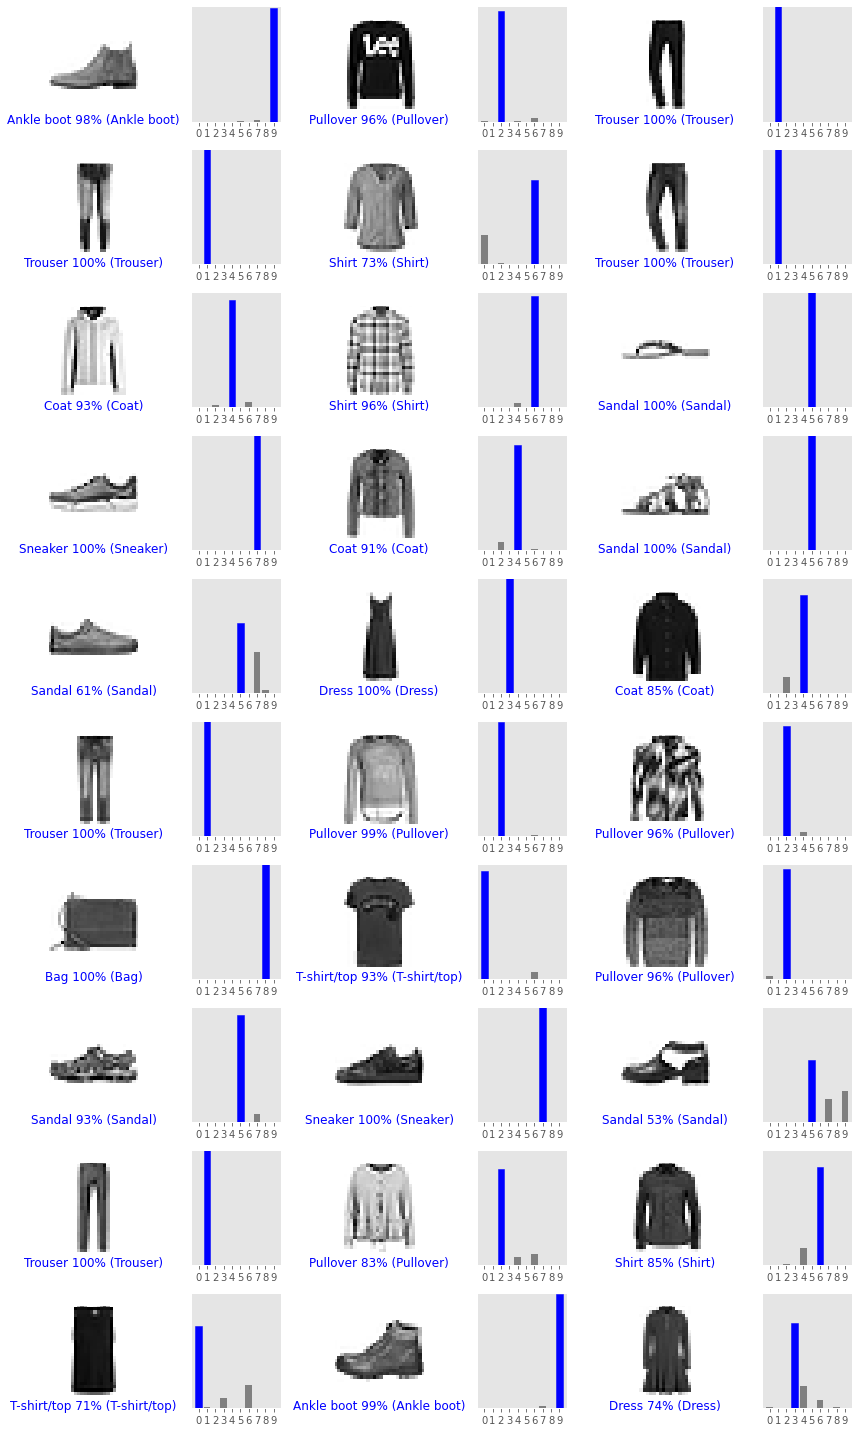

In [55]:
clasfication_report(modelMLP)

# MLP 1

In [0]:
modelMLP1 = keras.Sequential([
  keras.layers.Flatten(input_shape=(28,28)),
  keras.layers.Dense(256, activation='tanh', kernel_initializer = 'he_normal' ,input_shape=(28*28,)),
  keras.layers.Dense(128, activation='tanh',kernel_initializer = 'he_normal'),
  keras.layers.Dense(100, activation='tanh',kernel_initializer = 'he_normal'),
  keras.layers.Dense(10, activation='softmax',kernel_initializer = 'he_normal')
])

In [0]:
modelMLP1.compile(loss='categorical_crossentropy',
			  optimizer='adam',
			  metrics=['accuracy'])

In [58]:
modelMLP1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1010      
Total params: 247,766
Trainable params: 247,766
Non-trainable params: 0
_________________________________________________________________


In [59]:
historyMLP1 = modelMLP1.fit(x_train, y_train,
					batch_size=64,
					epochs=200,
					verbose=2,
          callbacks=[early_stopping_cb],
					validation_data=(x_valid, y_valid))

Epoch 1/200
750/750 - 3s - loss: 0.4807 - accuracy: 0.8254 - val_loss: 0.4170 - val_accuracy: 0.8516
Epoch 2/200
750/750 - 3s - loss: 0.3680 - accuracy: 0.8636 - val_loss: 0.3713 - val_accuracy: 0.8676
Epoch 3/200
750/750 - 3s - loss: 0.3327 - accuracy: 0.8761 - val_loss: 0.3378 - val_accuracy: 0.8802
Epoch 4/200
750/750 - 3s - loss: 0.3082 - accuracy: 0.8861 - val_loss: 0.3492 - val_accuracy: 0.8761
Epoch 5/200
750/750 - 3s - loss: 0.2909 - accuracy: 0.8893 - val_loss: 0.3264 - val_accuracy: 0.8832
Epoch 6/200
750/750 - 3s - loss: 0.2765 - accuracy: 0.8967 - val_loss: 0.3369 - val_accuracy: 0.8788
Epoch 7/200
750/750 - 3s - loss: 0.2667 - accuracy: 0.8991 - val_loss: 0.3202 - val_accuracy: 0.8866
Epoch 8/200
750/750 - 3s - loss: 0.2539 - accuracy: 0.9040 - val_loss: 0.3221 - val_accuracy: 0.8867
Epoch 9/200
750/750 - 3s - loss: 0.2427 - accuracy: 0.9097 - val_loss: 0.3394 - val_accuracy: 0.8840
Epoch 10/200
750/750 - 3s - loss: 0.2367 - accuracy: 0.9116 - val_loss: 0.3255 - val_accura

313/313 - 1s - loss: 0.3632 - accuracy: 0.8877
Train Loss     : 0.12088
Validation Loss: 0.41747
Test Loss      : 0.36315
---
Train Accuracy     : 0.95444
Validation Accuracy: 0.88475
Test Accuracy      : 0.88770



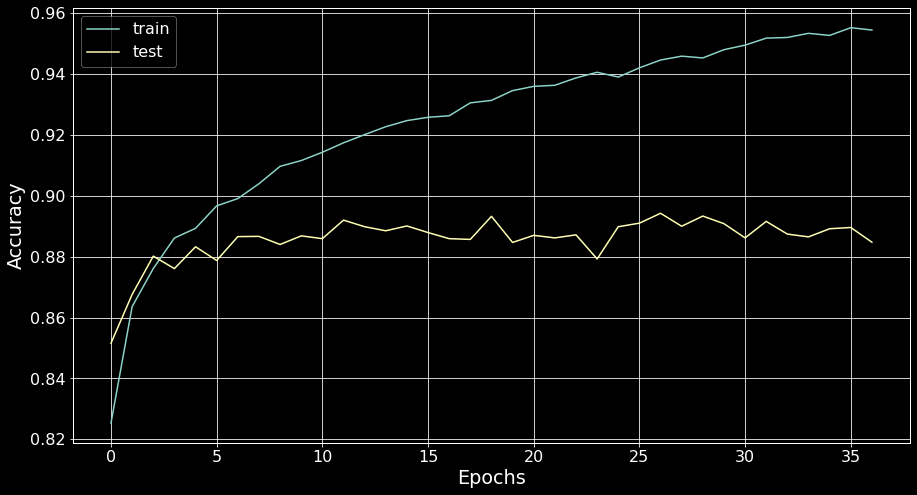

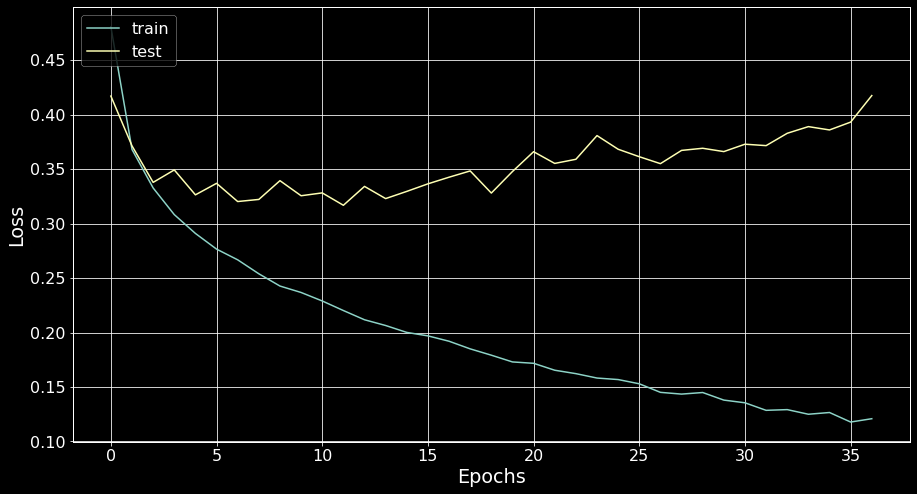

In [60]:
evaluateModel(modelMLP1,historyMLP1)
print()
plotAccuracy(historyMLP1)
print()
plotLoss(historyMLP1)

Correctly predicted classes: 8877
Incorrectly predicted classes: 1123

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.84      0.84      1000
     Trouser       0.97      0.98      0.98      1000
    Pullover       0.78      0.83      0.80      1000
       Dress       0.91      0.87      0.89      1000
        Coat       0.80      0.82      0.81      1000
      Sandal       0.97      0.96      0.96      1000
       Shirt       0.75      0.70      0.72      1000
     Sneaker       0.92      0.97      0.95      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.97      0.93      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000




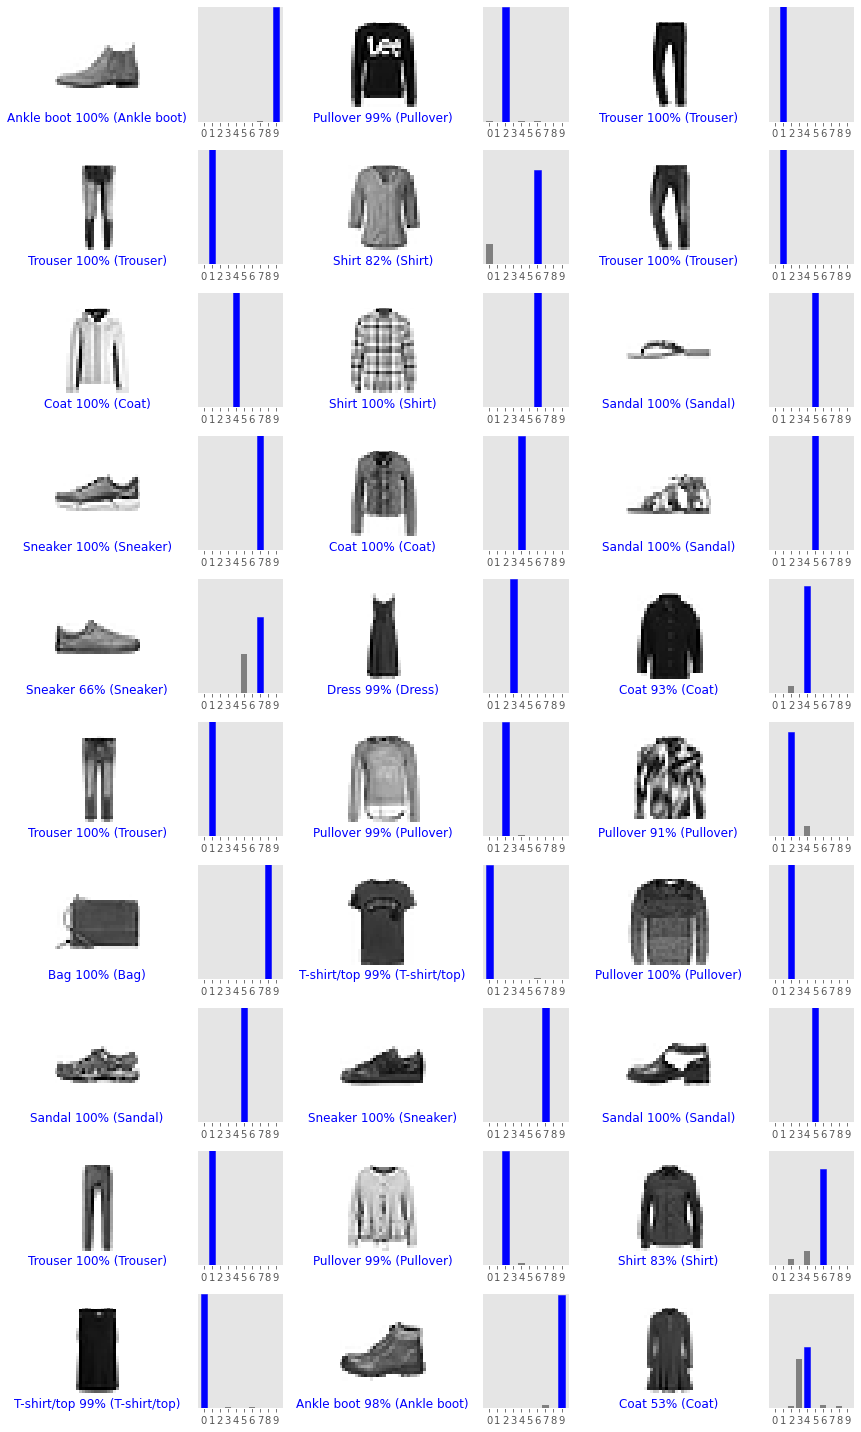

In [61]:
clasfication_report(modelMLP1)

# MLP 2

In [62]:
modelMLP2 = keras.Sequential([
  keras.layers.Flatten(input_shape=(28,28)),
  keras.layers.Dense(256, activation='tanh', kernel_initializer = 'he_normal' ,input_shape=(28*28,)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(128, activation='tanh',kernel_initializer = 'he_normal'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(100, activation='tanh',kernel_initializer = 'he_normal'),
  keras.layers.Dropout(0.1),
  keras.layers.Dense(10, activation='softmax',kernel_initializer = 'he_normal')
])
modelMLP2.compile(loss='categorical_crossentropy',
			  optimizer='adam',
			  metrics=['accuracy'])
modelMLP2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)              

In [63]:
historyMLP2 = modelMLP2.fit(x_train, y_train,
					batch_size=128,
					epochs=200,
					verbose=2,
          callbacks=[early_stopping_cb],
					validation_data=(x_valid, y_valid))

Epoch 1/200
375/375 - 2s - loss: 0.5999 - accuracy: 0.7808 - val_loss: 0.4654 - val_accuracy: 0.8302
Epoch 2/200
375/375 - 2s - loss: 0.4596 - accuracy: 0.8336 - val_loss: 0.4017 - val_accuracy: 0.8562
Epoch 3/200
375/375 - 2s - loss: 0.4203 - accuracy: 0.8471 - val_loss: 0.3881 - val_accuracy: 0.8623
Epoch 4/200
375/375 - 2s - loss: 0.3975 - accuracy: 0.8564 - val_loss: 0.3804 - val_accuracy: 0.8649
Epoch 5/200
375/375 - 2s - loss: 0.3804 - accuracy: 0.8610 - val_loss: 0.3944 - val_accuracy: 0.8545
Epoch 6/200
375/375 - 2s - loss: 0.3677 - accuracy: 0.8649 - val_loss: 0.3807 - val_accuracy: 0.8640
Epoch 7/200
375/375 - 2s - loss: 0.3593 - accuracy: 0.8681 - val_loss: 0.3671 - val_accuracy: 0.8663
Epoch 8/200
375/375 - 2s - loss: 0.3508 - accuracy: 0.8711 - val_loss: 0.3557 - val_accuracy: 0.8737
Epoch 9/200
375/375 - 2s - loss: 0.3459 - accuracy: 0.8727 - val_loss: 0.3474 - val_accuracy: 0.8761
Epoch 10/200
375/375 - 2s - loss: 0.3369 - accuracy: 0.8765 - val_loss: 0.3415 - val_accura

313/313 - 1s - loss: 0.3216 - accuracy: 0.8854
Train Loss     : 0.23965
Validation Loss: 0.32161
Test Loss      : 0.32158
---
Train Accuracy     : 0.90975
Validation Accuracy: 0.89183
Test Accuracy      : 0.88540



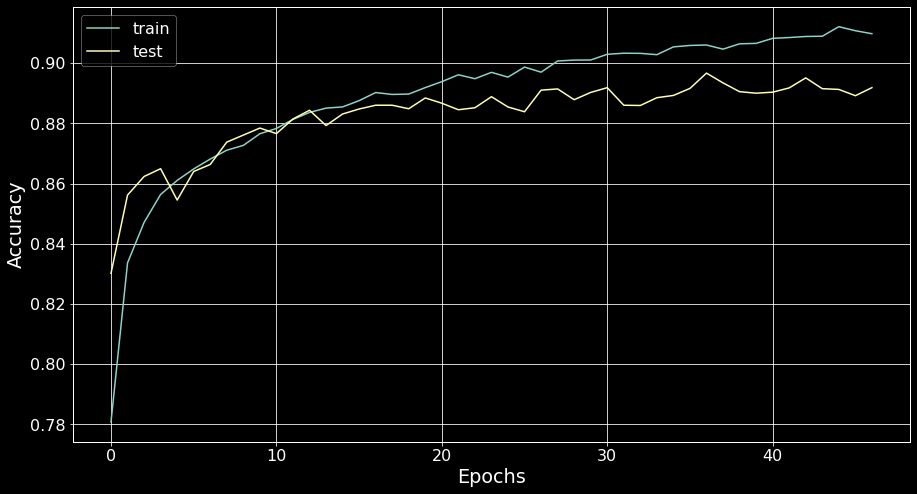

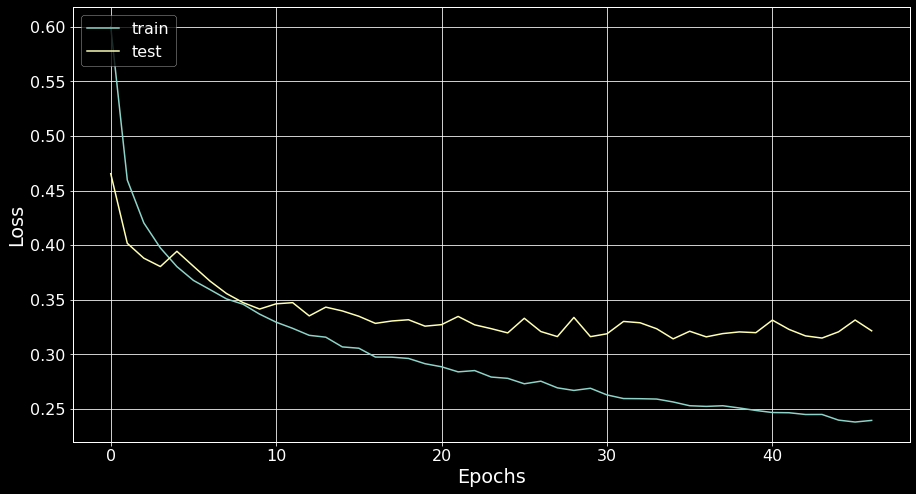

In [64]:
evaluateModel(modelMLP2,historyMLP2)
print()
plotAccuracy(historyMLP2)
print()
plotLoss(historyMLP2)

Correctly predicted classes: 8854
Incorrectly predicted classes: 1146

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.86      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.81      0.79      0.80      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.79      0.81      0.80      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.70      0.69      0.70      1000
     Sneaker       0.95      0.95      0.95      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000




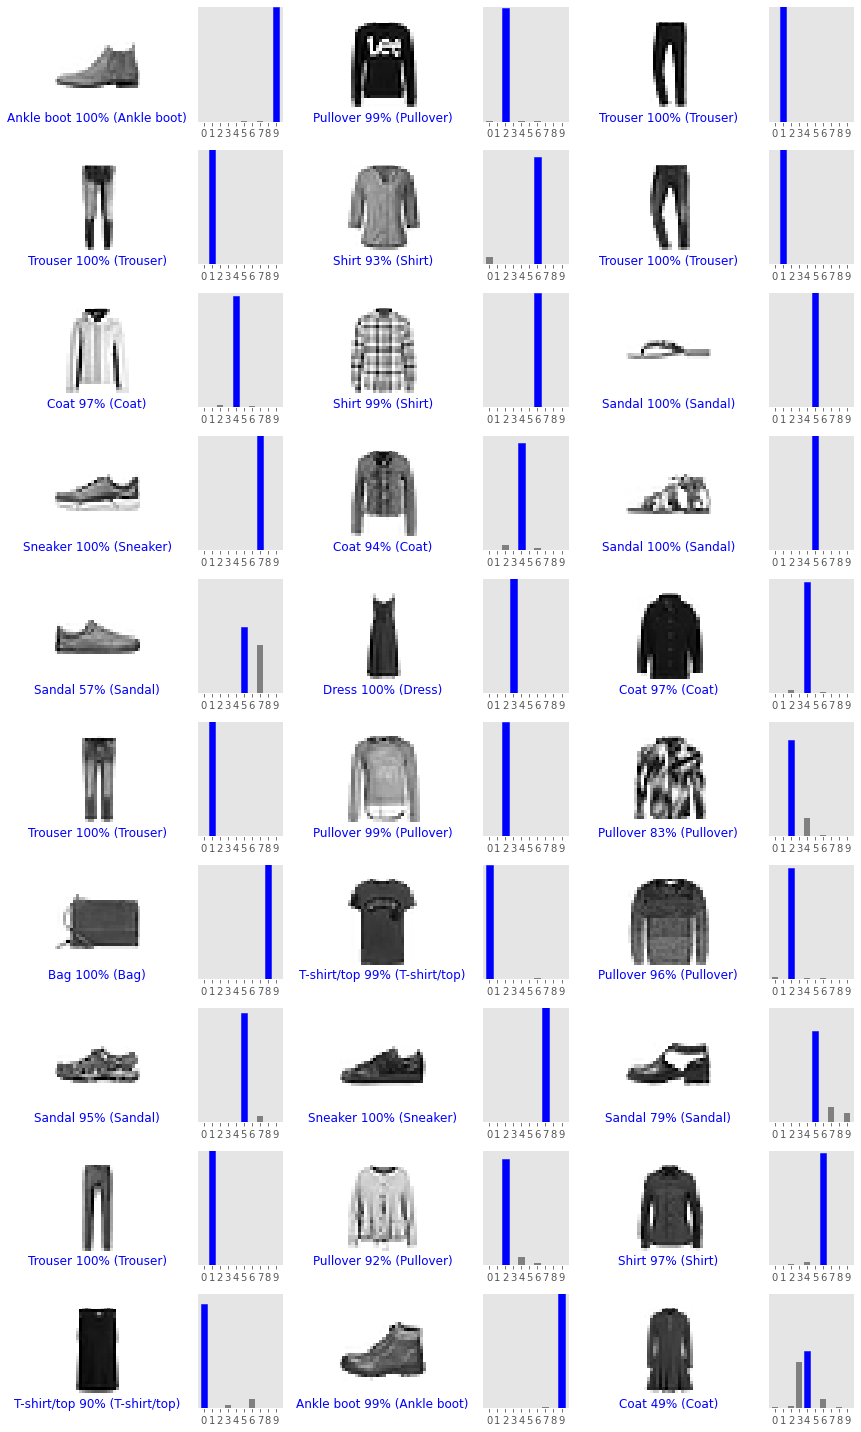

In [65]:
clasfication_report(modelMLP2)

# MLP 3

In [66]:
modelMLP3 = keras.Sequential([
  keras.layers.Flatten(input_shape=(28,28)),
  keras.layers.Dense(256, activation='relu', kernel_initializer = 'he_normal' ,input_shape=(28*28,)),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(128, activation='relu',kernel_initializer = 'he_normal'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(32, activation='relu',kernel_initializer = 'he_normal'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(10, activation='softmax',kernel_initializer = 'he_normal')
])
modelMLP3.compile(loss='categorical_crossentropy',
			  optimizer='adam',
			  metrics=['accuracy'])
modelMLP3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)               

In [67]:
historyMLP3 = modelMLP3.fit(x_train, y_train,
					batch_size=128,
					epochs=200,
					verbose=2,
					callbacks=[early_stopping_cb],
					validation_data=(x_valid, y_valid))

Epoch 1/200
375/375 - 2s - loss: 1.3078 - accuracy: 0.5322 - val_loss: 0.6189 - val_accuracy: 0.7812
Epoch 2/200
375/375 - 2s - loss: 0.7921 - accuracy: 0.7172 - val_loss: 0.5274 - val_accuracy: 0.8065
Epoch 3/200
375/375 - 2s - loss: 0.6882 - accuracy: 0.7569 - val_loss: 0.4904 - val_accuracy: 0.8167
Epoch 4/200
375/375 - 2s - loss: 0.6307 - accuracy: 0.7788 - val_loss: 0.4579 - val_accuracy: 0.8432
Epoch 5/200
375/375 - 2s - loss: 0.6008 - accuracy: 0.7935 - val_loss: 0.4507 - val_accuracy: 0.8423
Epoch 6/200
375/375 - 2s - loss: 0.5785 - accuracy: 0.8002 - val_loss: 0.4236 - val_accuracy: 0.8547
Epoch 7/200
375/375 - 2s - loss: 0.5635 - accuracy: 0.8068 - val_loss: 0.4222 - val_accuracy: 0.8537
Epoch 8/200
375/375 - 2s - loss: 0.5456 - accuracy: 0.8101 - val_loss: 0.4206 - val_accuracy: 0.8572
Epoch 9/200
375/375 - 2s - loss: 0.5238 - accuracy: 0.8181 - val_loss: 0.4025 - val_accuracy: 0.8610
Epoch 10/200
375/375 - 2s - loss: 0.5209 - accuracy: 0.8204 - val_loss: 0.4057 - val_accura

313/313 - 1s - loss: 0.3813 - accuracy: 0.8798
Train Loss     : 0.36274
Validation Loss: 0.38067
Test Loss      : 0.38134
---
Train Accuracy     : 0.87262
Validation Accuracy: 0.88325
Test Accuracy      : 0.87980



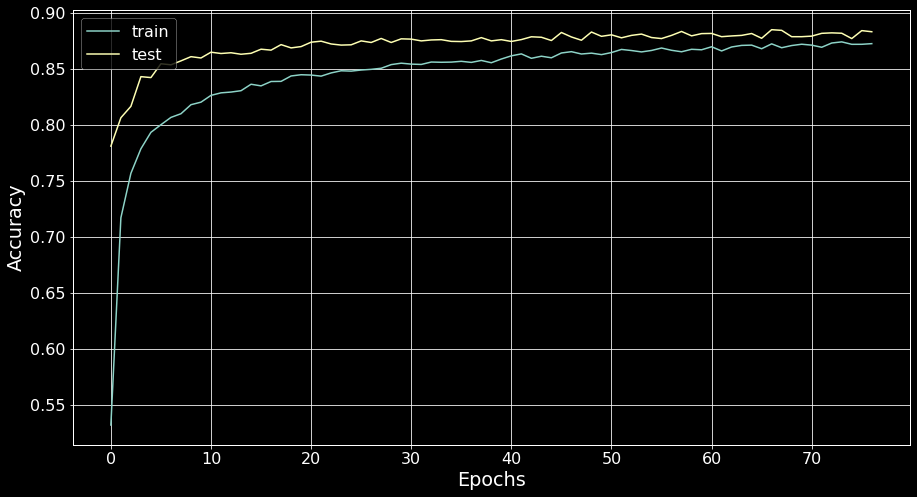

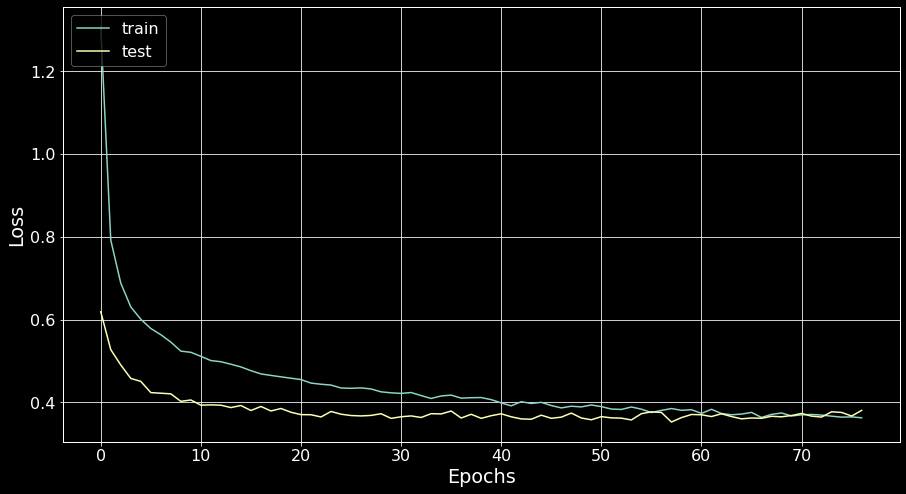

In [68]:
evaluateModel(modelMLP3,historyMLP3)
print()
plotAccuracy(historyMLP3)
print()
plotLoss(historyMLP3)

Correctly predicted classes: 8798
Incorrectly predicted classes: 1202

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.84      0.84      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.76      0.82      0.79      1000
       Dress       0.84      0.93      0.88      1000
        Coat       0.78      0.79      0.79      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.73      0.60      0.66      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.98      0.96      0.97      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000




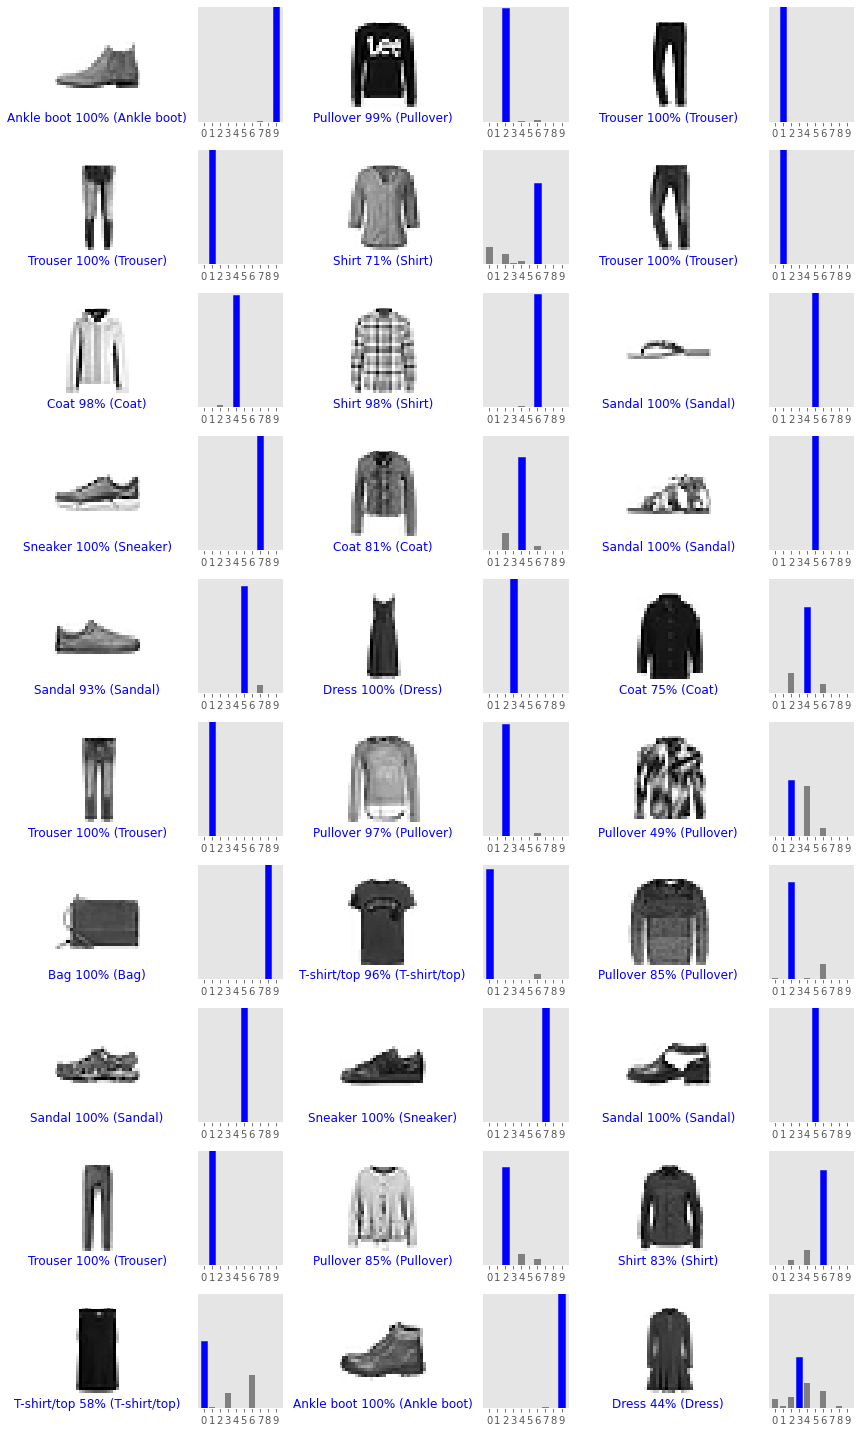

In [69]:
clasfication_report(modelMLP3)